In [1]:
import obspy
import seisbench
import seisbench.models as sbm
import matplotlib.pyplot as plt
import numpy as np
from obspy import UTCDateTime


import ipynb.fs 
from .defs.EDA_and_Preprocessing import Data_Sorter
from .defs.Load_and_Store_Models import load_models_pickle

In [2]:
# Takes in a dictionary with the stored files, the key that contains
# the desired file and the path to the files.

def stream_creator(path, dict, key, plot=None):
    stream = obspy.read(path + dict[key][0])
    stream += obspy.read(path + dict[key][1])
    stream += obspy.read(path + dict[key][2])
    
    if plot:
        fig = plt.figure(figsize=(8,6))
        stream.plot(bgcolor='gainsboro', fig=fig)
    
    return stream

In [14]:
# This function takes the an annotated stream and a varialbe thresold and selects 100 indices of the 
# largest (arbitrarily high) prediction probabilites, then it uses those indices to determine
# if the corresponding data point is above a provided threshold. We store the indices that satisfy these 
# conditions in an array. We then return a dictionary of these arrays.

def annotation_index_selector(annotations, threshold):
    indices_dict = {}
    
    for i in range(len(annotations)):  
        data_ary = annotations[i].data
        
        indices =  np.argpartition(data_ary, -100)[-100:]
        
        thresh_indices = [idx for idx in indices if (data_ary[idx] >= threshold)] 
                
        indices_dict['strm_' + str(i) + '_indices'] = thresh_indices
        
    return indices_dict

In [4]:
# Takes in the original stream, the annotated stream and the indices dictionary that is returned when 
# calling Annotation_Index_Selector. Plots 3 subplots: the top plot is the original stream, the second
# plot is the annotated stream and the final plot are the locations where the annotation predicts 
# the picks to be. 

def wave_plotter(stream, annotations, prediction_indices_dict):
    fig = plt.figure(figsize=(16, 10))
    axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
                
    offset = annotations[0].stats.starttime - stream[0].stats.starttime
    for i in range(3):
        axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
        if annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
            axs[1].plot(annotations[i].times() + offset, annotations[i].data, label=annotations[i].stats.channel)
        
    
    # This is dumb. Need to think of a better way of doing this.
    filler = list(prediction_indices_dict.keys())
    
    for i in range(len(prediction_indices_dict.keys())):
        for idx in prediction_indices_dict[filler[i]]:
            axs[2].plot(annotations[i].times()[idx], annotations[i].data[idx],  'r|-', markersize=7)
        

    axs[0].legend()
    axs[1].legend()
    plt.show()
    return 0

In [5]:
def denoiser(stream, model, plot=None):    
    denoised_stream =  model.annotate(stream)
    
    if plot:
        fig = plt.figure(figsize=(8,6))
        denoised_stream.plot(bgcolor='gainsboro', fig=fig)
    
    return denoised_stream

In [6]:
def annotate(stream, model, threshold):
    predictions = {}
    
    predictions['annotation'] = model.annotate(stream)
    predictions['picks'] = model.classify(stream, P_threshold=threshold, S_threshold=threshold)
    
    return predictions

In [7]:
# Picks out the station data that we will use.
path = '/global/scratch/users/taira/mleq/mseed/'
collected_data = !ls /global/scratch/users/taira/mleq/mseed/

sorted_dict = Data_Sorter(collected_data)

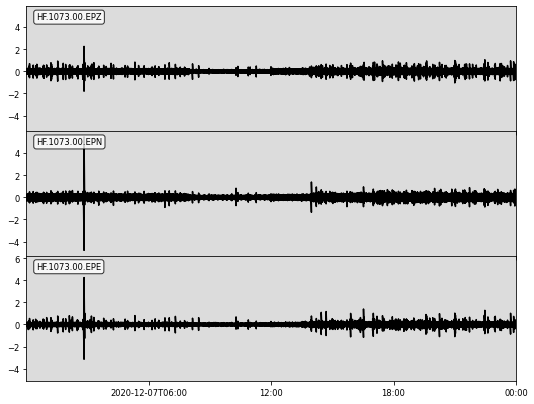

In [8]:
# Initializes the stream.
stream = stream_creator(path, sorted_dict, '1073', True)

In [9]:
# Loads the nested dictionaries that hold all of the pretrained models from the pickled file.
models = load_models_pickle()
print(models.keys(), '\n\n', models['pn_model'].keys())

dict_keys(['pn_model', 'eqt_model', 'gpd_model', 'denoiser']) 

 dict_keys(['stead', 'geofon', 'neic'])


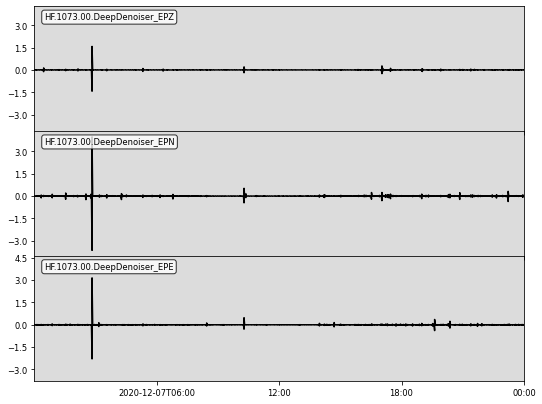

In [10]:
# Runs the denoiser model on the stream. Gets out a denoised stream.
denoised_stream = denoiser(stream, models['denoiser'], plot=True)

In [11]:
# Runs the selected model on the original and denoised stream.

predictions = annotate(stream, models['pn_model']['geofon'], threshold=.95)
predicitons_denoised = annotate(denoised_stream, models['pn_model']['geofon'], threshold=.95)

In [15]:
# Pushes both prediction streams to the annotation_index_selector to get a dictionary containing
# the characteristic curves that meet the threshold condition.

prediction_indices_dict = annotation_index_selector(predictions['annotation'], threshold=.99)
prediction_indices_dict_deno = annotation_index_selector(predicitons_denoised['annotation'], threshold=.85)

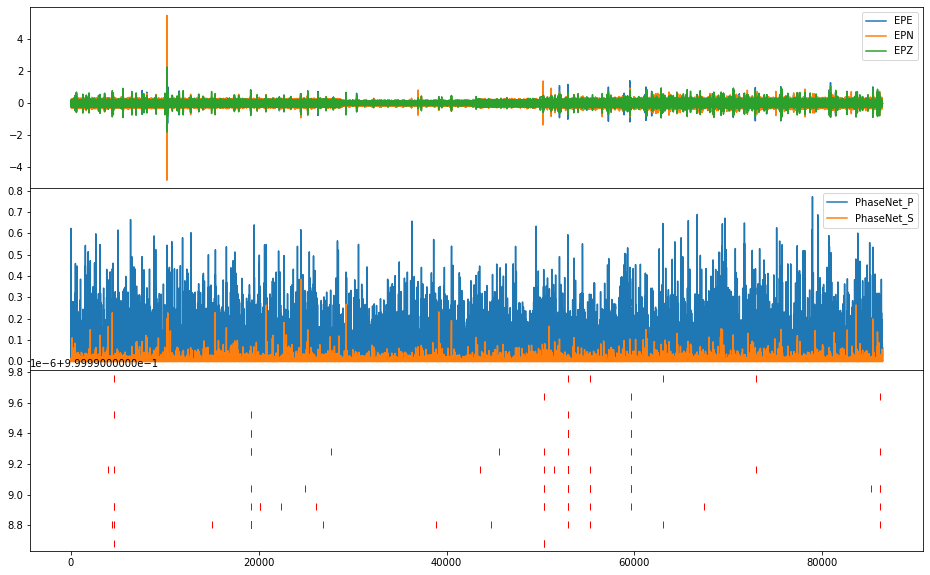

0

In [16]:
# Plots the original stream, model predicted stream and the picks.
wave_plotter(stream, predictions['annotation'], prediction_indices_dict)

/global/home/groups/fc_ambient/seisbench/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


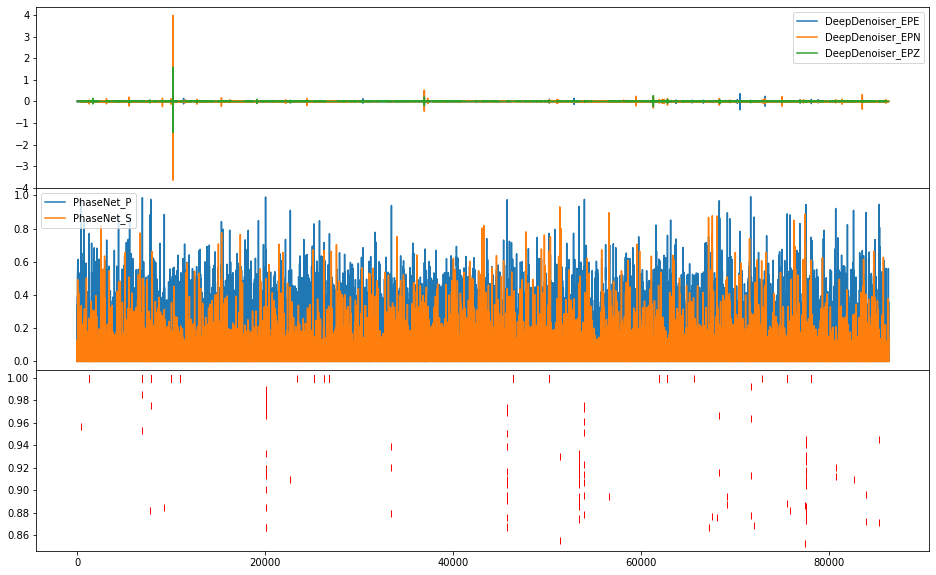

0

In [17]:
# Plots the denoised stream, model predicted stream and the picks.
wave_plotter(denoised_stream, predicitons_denoised['annotation'], prediction_indices_dict_deno)

In [24]:
for pick in predicitons_denoised['picks']:
    print(pick)

HF.1073.00	2020-12-07T00:07:34.402000Z	P
HF.1073.00	2020-12-07T01:56:20.192000Z	P
HF.1073.00	2020-12-07T02:11:14.662000Z	P
HF.1073.00	2020-12-07T05:34:53.842000Z	P
HF.1073.00	2020-12-07T12:43:34.072000Z	P
HF.1073.00	2020-12-07T15:00:33.502000Z	P
HF.1073.00	2020-12-07T18:59:53.382000Z	P
HF.1073.00	2020-12-07T19:55:34.412000Z	P
HF.1073.00	2020-12-07T19:55:34.582000Z	P


In [ ]:
'''
 - For quick analysis run the cells with the function definitions and the 4 cells below.
 - The denoiser is optional, produces varying prediciton results and pretty time intensive. Feel free
     to comment it out and not use it.
'''

# # # Loads data, models and denoises the data.
# path = '/global/scratch/users/taira/mleq/mseed/'
# collected_data = !ls /global/scratch/users/taira/mleq/mseed/

# sorted_dict = Data_Sorter(collected_data)
# stream = stream_creator(path, sorted_dict, '1073', plot=True)
# models = load_models_pickle()

# denoised_stream = denoiser(stream, models['denoiser'], plot=True)

In [ ]:
# # Runs predicions on original and denoised data.
# prediction_dict = annotate(stream, models['pn_model']['stead'], threshold=.95)
# predicitons_dict_denoised = annotate(denoised_stream, models['pn_model']['stead'], threshold=.95)

In [ ]:
# # Plots the results of the predictions.
# wave_plotter(stream, predictions['annotation'], prediction_dict)

In [ ]:
# wave_plotter(denoised_stream, predicitons_denoised['annotation'], predicitons_dict_denoised)